#### Import packages

In [1]:
import numpy as np
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.array as da

In [2]:
import mandulakenyer as mk # contains mandelbrot implementations
import utils # contains utilities

##### Setting parameters

In [3]:
RE_MIN = -2
RE_MAX = 1
IM_MIN = -1.5
IM_MAX = 1.5

size_params = [RE_MIN, RE_MAX, IM_MIN, IM_MAX] # for plotting

RE_SCALE = 1000
IM_SCALE = 1000

T = 2 # threshold
I = 100 # iteration

# previously, on NSC Handin
# for parallel computing
BEST_PROC_NUM = 5
BEST_CHUNKS_NUM = 20

# dask testing
CHUNK_SIZE_TEST = 1000

In [4]:
re = [RE_MIN, RE_MAX, RE_SCALE]
im = [IM_MIN, IM_MAX, IM_SCALE]

# list of data types, None was used last time
dt_lst = [ None, 'float16', 'float32', 'float64'] 

df = pd.DataFrame()
iter_num = 5 # for timeit, how many times to iter through to measure execution time

comp_lst ={
    None : "complex", # last time this was used
    "float16" : "complex64", # complex64 is two float32
    "float32" : "complex64", # complex64 is two float32
    "float64" : "complex128" # complex128 is two float64
}

#### Measuring time the different implementations with different data types 

In [17]:
for dt in dt_lst:
    t = timeit.Timer(lambda: mk.naive(re, im, dt, I, T)).timeit(iter_num)
    new_row = pd.DataFrame(utils.add_new_row('naive', dt, t))
    df = pd.concat([df, new_row], ignore_index=True)

In [18]:
for dt in dt_lst:
    comp_dt = comp_lst[dt]
    t = timeit.Timer(lambda: mk.vectorized(re, im, dt, comp_dt, I, T)).timeit(iter_num)
    new_row = pd.DataFrame(utils.add_new_row('vectorized', dt, t))
    df = pd.concat([df, new_row], ignore_index=True)

In [19]:
for dt in dt_lst:
    t = timeit.Timer(
            lambda: mk.parallelize(mk.parallel_mb, BEST_PROC_NUM, BEST_CHUNKS_NUM, re, im, dt, I, T)
        ).timeit(iter_num)
    
    
    new_row = pd.DataFrame(utils.add_new_row('parallel', dt, t))
    df = pd.concat([df, new_row], ignore_index=True)

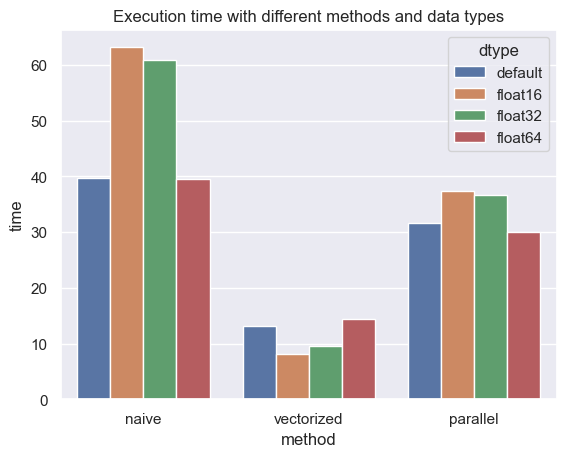

In [20]:
sns.set()
sns.barplot(x='method', y='time', hue='dtype', data=df)
plt.title("Execution time with different methods and data types")
plt.show()

Vectorization is way faster than the other methods among the different data types.

#### Dask implementation

##### Test on Dask

In [6]:
re_val, im_val = mk.create_imre(re, im)
c = re_val + im_val[:, np.newaxis]

In [15]:
# checking if dask implementation working properly
C_test = da.from_array(c, chunks=(CHUNK_SIZE_TEST, CHUNK_SIZE_TEST))
M = mk.dask_parallel(mk.dask_mb, C_test, CHUNK_SIZE_TEST, I, T)

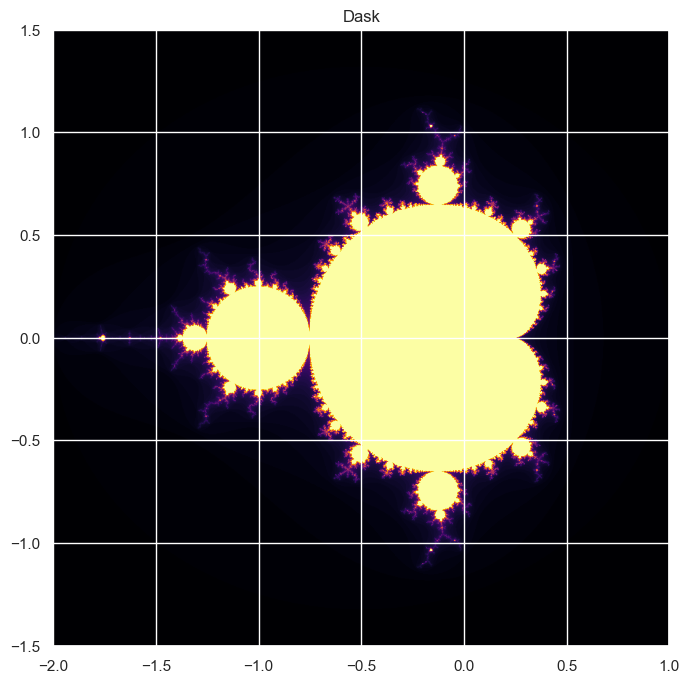

In [16]:
M_ = M.compute()
utils.plotting(M_, "Dask", size_params)

##### Testing for different chunksizes

In [7]:
chunk_sizes = [200, 500, 1000]
time_dusk = pd.DataFrame()

for chunk in chunk_sizes:

    C = da.from_array(c, chunks=(chunk, chunk))
    t = timeit.Timer(lambda: mk.dask_parallel(mk.dask_mb, C, chunk, I, T)).timeit(iter_num)
    new_row = pd.DataFrame({'chunk_number' : [chunk], 'time' : [t]})
    time_dusk = pd.concat([time_dusk, new_row], ignore_index=True)

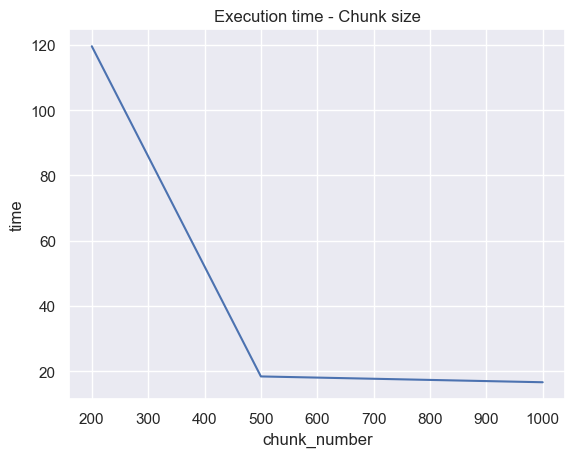

In [10]:
sns.set()
sns.lineplot(x='chunk_number', y='time', data=time_dusk)
plt.title("Execution time - Chunk size")
plt.show()

Execution time reduced by increased chunksize (on a small scale).

##### Comparasion with NumPy

In [11]:
scales = [200, 500, 1000]
chunk_size = {
    200 : 100,
    500 : 250,
    1000 : 500
}
time_comp = pd.DataFrame()

for scale in scales:
    
    c_dask = da.from_array(c, chunks=(chunk_size[scale], chunk_size[scale]))
    
    t_dask = timeit.Timer(lambda: mk.dask_parallel(mk.dask_mb, C, chunk_size[scale], I, T)).timeit(iter_num)
    t_numpy = timeit.Timer(lambda: mk.vectorized(re, im, None, "complex", I, T)).timeit(iter_num)

    new_row_numpy = pd.DataFrame({'scale' : [scale], 'method': 'numpy', 'time' : [t_numpy]})
    new_row_dask = pd.DataFrame({'scale' : [scale], 'method': 'dask', 'time' : [t_dask]})
    time_comp = pd.concat([time_comp, new_row_numpy, new_row_dask], ignore_index=True)

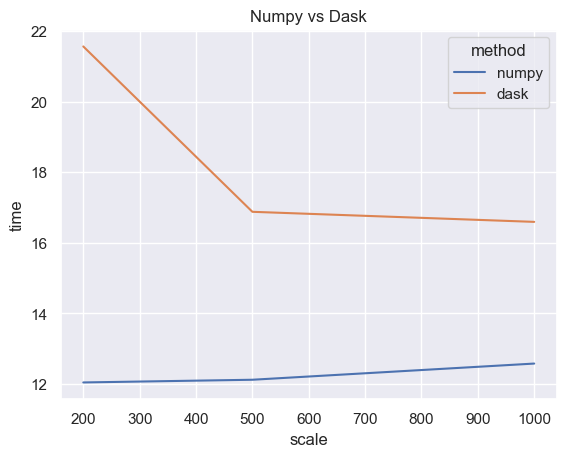

In [14]:
sns.set()
sns.lineplot(x='scale', y='time', hue='method', data=time_comp)
plt.title("Numpy vs Dask")
plt.show()

All together NumPy performed better, but that can be because of the small size of the dataset.